## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.8]
redice_lr_patient = [3,8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s-%s-%s" % (optim,reduce_factor,reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 2s 46us/step - loss: 2.2415 - accuracy: 0.2504 - val_loss: 2.1639 - val_accuracy: 0.2058
Epoch 2/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8100 - accuracy: 0.3688 - val_loss: 2.0285 - val_accuracy: 0.2798
Epoch 3/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.7032 - accuracy: 0.4044 - val_loss: 1.8740 - val_accuracy: 0.3484
Epoch 4/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.6434 - accuracy: 0.4258 - val_loss: 1.7684 - val_accuracy: 0.3926
Epoch 5/15
50000/50000 [==============================] - 2s 34us/step - loss: 1.5965 - accuracy: 0.4427 - val_loss: 1.7102 - val_accuracy: 0.4074
Epoch 6/15
50000/50000 [==============================] - 2s 34us/step - loss: 1.5578 - accuracy: 0.4566 - val_loss: 1.6464 - val_accuracy: 0.4318
Epoch 7/15
50000/50000 [==============================] - 2s 34us/st

50000/50000 [==============================] - 2s 37us/step - loss: 1.3295 - accuracy: 0.5341 - val_loss: 1.6385 - val_accuracy: 0.4184
Epoch 6/15
50000/50000 [==============================] - 2s 37us/step - loss: 1.2830 - accuracy: 0.5482 - val_loss: 2.0419 - val_accuracy: 0.3126
Epoch 7/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.2347 - accuracy: 0.5657 - val_loss: 1.7203 - val_accuracy: 0.4270
Epoch 8/15
50000/50000 [==============================] - 2s 37us/step - loss: 1.1955 - accuracy: 0.5791 - val_loss: 1.6410 - val_accuracy: 0.4299

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 9/15
50000/50000 [==============================] - 2s 43us/step - loss: 1.1086 - accuracy: 0.6126 - val_loss: 1.4155 - val_accuracy: 0.4956
Epoch 10/15
50000/50000 [==============================] - 2s 40us/step - loss: 1.0703 - accuracy: 0.6288 - val_loss: 1.4865 - val_accuracy: 0.4756
Epoch 11/15
50000/50000 [======================

50000/50000 [==============================] - 2s 38us/step - loss: 1.1899 - accuracy: 0.5827 - val_loss: 1.5127 - val_accuracy: 0.4749
Epoch 10/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.1582 - accuracy: 0.5939 - val_loss: 1.4549 - val_accuracy: 0.4840
Epoch 11/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.1261 - accuracy: 0.6054 - val_loss: 1.6936 - val_accuracy: 0.4230
Epoch 12/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.1021 - accuracy: 0.6138 - val_loss: 1.5296 - val_accuracy: 0.4727
Epoch 13/15
50000/50000 [==============================] - 2s 37us/step - loss: 1.0752 - accuracy: 0.6224 - val_loss: 1.4954 - val_accuracy: 0.4762

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00024000001139938833.
Epoch 14/15
50000/50000 [==============================] - 2s 37us/step - loss: 1.0396 - accuracy: 0.6376 - val_loss: 1.4949 - val_accuracy: 0.4791
Epoch 15/15
50000/50000 [=================

Epoch 13/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.0288 - accuracy: 0.6424 - val_loss: 1.3965 - val_accuracy: 0.5076
Epoch 14/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.0113 - accuracy: 0.6496 - val_loss: 1.3899 - val_accuracy: 0.5087
Epoch 15/15
50000/50000 [==============================] - 2s 36us/step - loss: 0.9967 - accuracy: 0.6515 - val_loss: 1.4270 - val_accuracy: 0.5020
Numbers of exp: 9, reduce_factor: 0.30, reduce_patient: 8
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
__________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 2s 48us/step - loss: 1.9350 - accuracy: 0.3344 - val_loss: 2.1235 - val_accuracy: 0.2126
Epoch 2/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.6541 - accuracy: 0.4208 - val_loss: 1.9540 - val_accuracy: 0.3038
Epoch 3/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.5522 - accuracy: 0.4575 - val_loss: 1.8119 - val_accuracy: 0.3568
Epoch 4/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.4855 - accuracy: 0.4805 - val_loss: 1.6577 - val_accuracy: 0.4304
Epoch 5/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.4384 - accuracy: 0.4985 - val_loss: 1.7101 - val_accuracy: 0.3855
Epoch 6/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.3960 - accuracy: 0.5137 - val_loss: 1.9017 - val_accuracy: 0.3393
Epoch 7/15
50000/50000 [==============================] - 2s 36us/st

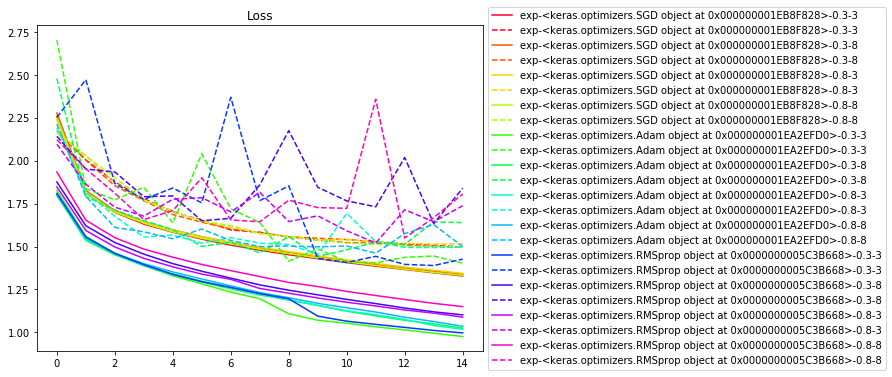

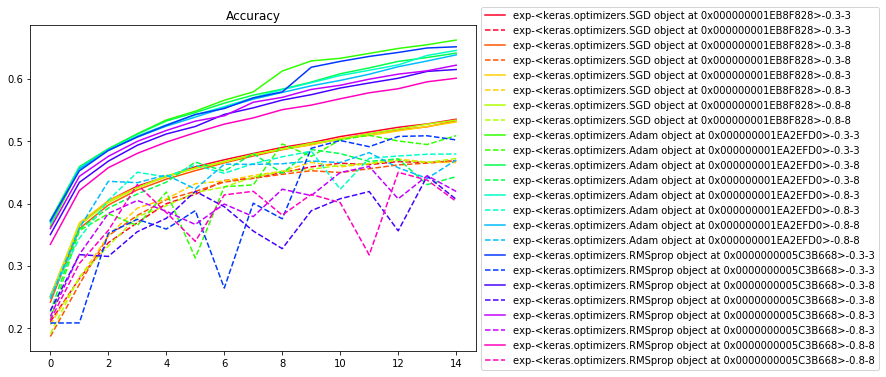

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()